In [1]:
import numpy as np
import dedalus.public as d3
import matplotlib.pyplot as plt

In [1]:
import numpy as np 
a = 6.99e7
T = 9.925*3600
L = 1e7
4 * np.pi / a / a / T * (L**3) / 100


0.7198176581830783

In [2]:
# physical parameters
L_scale = 6.99e7/2/np.pi  # 6.99e7 m is the radius of Jupiter, divided by 2π sets a natural length scale in units 2π.
Omega_scale = 2 * np.pi /(9.925*3600)/4/(np.pi)**2
f0 = 8 * np.pi 
g0 = 24 # gravity at the surface of Jupiter in m/s^2
p0 = 1e4 # reference pressure in Pa
T0 = 200 # reference temperature in K
Rd = 8.315/0.002 # gas constant 
H1 = 1e5/ L_scale
delta = 1
H2 = delta * H1
g = g0 /(L_scale*Omega_scale**2)  # g0 = 24; g = g0/(L_scale*Omega_scale^2)     # gravity
rho1 = p0 / Rd / T0 * np.exp(g0 * H1 / Rd / T0) # density at the surface of Jupiter
rho2 = p0 / Rd / T0 * (np.exp(g0 * (H1 + H2) / Rd / T0)) # density at the surface of Jupiter
gprime = g * (rho2 - rho1) / rho2 # reduced gravity

gamma = 2.0
u0 = 50  / L_scale / Omega_scale
F1 = f0**2 / gprime / H1
F2 = f0**2 / gprime / H2

kphi = 6
# m = 6
# Nphi = 2 * m + 2
Nr = 64
dtype = np.complex128

disk_r = np.pi


In [3]:
# Bases
coords = d3.PolarCoordinates('phi', 'r')
dist = d3.Distributor(coords, dtype=dtype)
disk = d3.DiskBasis(coords, shape=(1, Nr), radius=disk_r, dtype=dtype)
phi, r = dist.local_grids(disk)

# Fields
s = dist.Field(name='s')
psi1 = dist.Field(name='psi1', bases=disk)
psi2 = dist.Field(name='psi2', bases=disk)
tau_psi1 = dist.Field(name='tau_psi1', bases=disk.edge)
tau_psi2 = dist.Field(name='tau_psi2', bases=disk.edge)


In [4]:
# Substitutions
dt = lambda A: s*A
lift_basis = disk.derivative_basis(2)
lift = lambda A: d3.Lift(A, lift_basis, -1)
# define a unit vector in the azimuthal direction 
dphi = lambda A: 1j*kphi*A  # azimuthal derivative dphi(A)
r_field = dist.Field(name='r_field', bases=disk)
r_field['g'] = r  # assign the grid values to the field


In [5]:
# Background
Qr1 = dist.Field(name='Qr1', bases=disk.radial_basis)
Qr2 = dist.Field(name='Qr2', bases=disk.radial_basis)
Qr1['g'] = - gamma * r - 2 * F1 * u0 * r
Qr2['g'] = - gamma * r + 2 * F2 * u0 * r


In [6]:
# Problem
problem = d3.EVP([psi1, psi2, tau_psi1, tau_psi2], eigenvalue=s, namespace=locals())
# q1 = lap(psi1) - F1 * (psi1 - psi2)
# q2 = lap(psi2) + F2 * (psi1 - psi2)
problem.add_equation("dt((lap(psi1))-F1*(psi1-psi2))+ u0 * r_field * dphi((lap(psi1))-F1*(psi1-psi2)) - Qr1 * dphi(psi1) +lift(tau_psi1)=0")
problem.add_equation("dt((lap(psi2))+F2*(psi1-psi2))- u0 * r_field * dphi((lap(psi2))+F2*(psi1-psi2)) - Qr2 * dphi(psi2) +lift(tau_psi2)=0")
problem.add_equation("psi1(r=disk_r) = 0")
problem.add_equation("psi2(r=disk_r) = 0")
# problem.add_equation("psi1(r=0) = 0")
# problem.add_equation("psi2(r=0) = 0")
# problem.add_equation("dphi(psi1)(r=1) = 0") 


{'eqn': interp(<Field 140643312919376>, r=3.141592653589793),
 'LHS': interp(<Field 140643312919376>, r=3.141592653589793),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'valid_modes': array([[ True]]),
 'M': 0,
 'L': interp(<Field 140643312919376>, r=3.141592653589793),
 'domain': <dedalus.core.domain.Domain at 0x7fea12a18c20>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [7]:
solver = problem.build_solver()
# sp = solver.subproblems_by_group[(1, None)]
sp = solver.subproblems[0]
solver.solve_dense(sp)
# solver.solve_dense(solver.subproblems[0])
evals = solver.eigenvalues[np.isfinite(solver.eigenvalues)]
evals = evals[np.argsort(-evals.real)]
print(f"Slowest decaying mode: λ = {evals[0]}")
solver.set_state(np.argmin(np.abs(solver.eigenvalues - evals[0])), sp.subsystems[0])
# solver.set_state(np.argmin(np.abs(solver.eigenvalues - evals[0])), 0)


2025-07-17 08:16:41,187 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s
Slowest decaying mode: λ = (18.93201520340718+0.015386760115815985j)


In [8]:

# Plot eigenfunction
scales = (32, 4)
# ω = d3.div(d3.skew(psi1)).evaluate()
# ω.change_scales(scales)
psi1.change_scales(scales)
psi2.change_scales(scales)
phi, r = dist.local_grids(disk, scales=scales)
x, y = coords.cartesian(phi, r)


In [9]:
psi1['g'].shape 

(1, 256)

In [10]:
psi1['g'][0,0]

np.complex128(-0.005469489213243689-0.013651385953711317j)

In [11]:
x[0].shape 

(256,)

In [12]:
r.shape

(1, 256)

Text(0.5, 1.0, '$\\psi_2$')

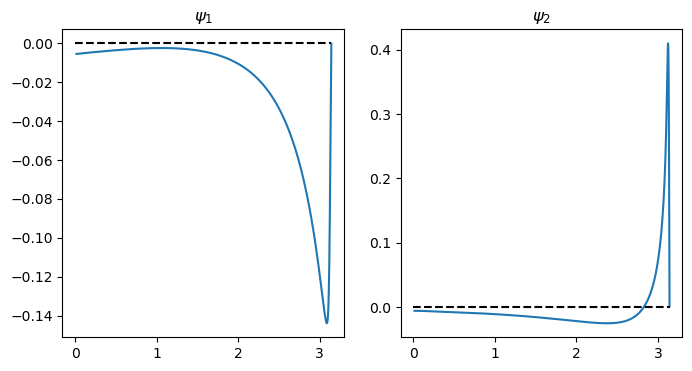

In [ ]:

cmap = 'RdBu_r'
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0,0].pcolormesh(x, y, psi1['g'].real, cmap=cmap)
# ax[0,0].set_title(r"$\psi_1$")
# ax[0,1].pcolormesh(x, y, psi2['g'].real, cmap=cmap)
# ax[0,1].set_title(r"$\psi_2$")
xxn = 0
ax[0].plot(r[0][xxn:], psi1['g'][0][xxn:].real )
ax[0].plot([0,disk_r],[0,0],'--',color='black')
ax[0].set_title(r"$\psi_1$")
ax[1].plot(r[0][xxn:], psi2['g'][0][xxn:].real )
ax[1].plot([0,disk_r],[0,0],'--',color='black')
ax[1].set_title(r"$\psi_2$")

# print(psi1['g'].real[:10] * L_scale)


In [ ]:
q1 = d3.Laplacian(psi1) - F1 * (psi1 - psi2)
q2 = d3.Laplacian(psi2) + F2 * (psi1 - psi2)

In [27]:
d3.Laplacian(psi1)['g'].shape 

(1, 64)

In [29]:
q1['g'].shape

(1, 64)

Text(0.5, 1.0, '$q_2$')

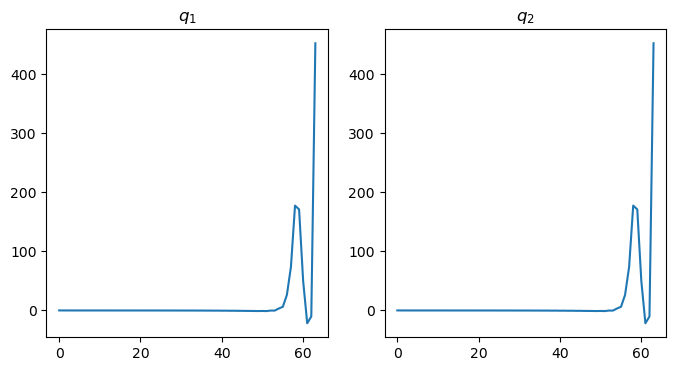

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
xxn = 0
ax[0].plot(d3.Laplacian(psi1)['g'][0][xxn:].real )
# ax[0].plot([0,disk_r],[0,0],'--',color='black')
ax[0].set_title(r"$q_1$")
ax[1].plot(d3.Laplacian(psi1)['g'][0][xxn:].real )
# ax[1].plot([0,disk_r],[0,0],'--',color='black')
ax[1].set_title(r"$q_2$")

Text(0.5, 1.0, '$q_2$')

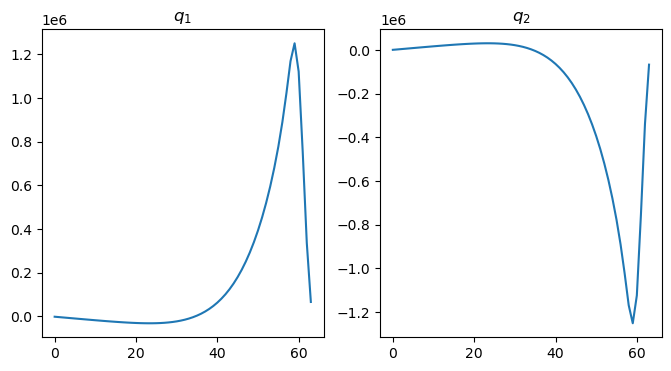

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
xxn = 0
ax[0].plot(q1['g'][0][xxn:].real )
# ax[0].plot([0,disk_r],[0,0],'--',color='black')
ax[0].set_title(r"$q_1$")
ax[1].plot(q2['g'][0][xxn:].real )
# ax[1].plot([0,disk_r],[0,0],'--',color='black')
ax[1].set_title(r"$q_2$")

In [14]:
d3.DiskBasis(coords, shape=(1, Nr), radius=np.pi, dtype=dtype)
psi1_disk = dist.Field(name='psi1_disk', bases=disk)